In [1]:
# Import dependencies

import torch
from torch import nn, save
from torch.optim import Adam
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.utils.data import ConcatDataset
from torchvision.transforms import ToTensor

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# %matplotlib widget
# %load_ext tensorboard
from torch.utils.tensorboard import SummaryWriter
from torchvision.utils import make_grid

# Set random seed for reproducibility
np.random.seed(42)

2024-01-14 10:59:49.782031: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Get data
original_ds = datasets.MNIST(root="data", download=True, train=True, transform=ToTensor())
print(f"Dataset size: {len(original_ds)}")


100%|██████████| 9912422/9912422 [00:00<00:00, 19008976.58it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 81572857.79it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 11215407.64it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 11825281.67it/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw

Dataset size: 60000


In [3]:
# print number of images in each class
labels = [y for _, y in original_ds]
unique, counts = np.unique(labels, return_counts=True)
for i in range(len(unique)):
    print(f"Number of {unique[i]}s: {counts[i]}")
print("----------------------------------")
print(f"Total number of images: {sum(counts)}")

Number of 0s: 5923
Number of 1s: 6742
Number of 2s: 5958
Number of 3s: 6131
Number of 4s: 5842
Number of 5s: 5421
Number of 6s: 5918
Number of 7s: 6265
Number of 8s: 5851
Number of 9s: 5949
----------------------------------
Total number of images: 60000


In [4]:
# make 4000 new images for each class using augmentation


# Define the augmentation transformations
augmentation_transform = transforms.Compose([
    transforms.RandomAffine(degrees=25, translate=(0.2, 0.2), scale=(0.8, 1.2)),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),

])


# Function to create augmented dataset for a specific class
def create_augmented_dataset(original_dataset, class_label, num_augmented_images, augmentation_transform):
    class_indices = [i for i, (image, label) in enumerate(original_dataset) if label == class_label]
    selected_indices = np.random.choice(class_indices, num_augmented_images, replace=False)

    augmented_dataset = datasets.MNIST(
        root="data",
        train=True,
        transform=transforms.Compose([
            transforms.Lambda(lambda x: augmentation_transform(x)),
            transforms.ToTensor()
        ])
    )

    augmented_dataset.data = [original_dataset.data[idx] for idx in selected_indices]
    augmented_dataset.targets = [original_dataset.targets[idx] for idx in selected_indices]

    return augmented_dataset


In [5]:
# Create augmented datasets for each class
num_augmented_images_per_class = 4000
augmented_ds = []

for class_label in range(10):
    augmented_dataset = create_augmented_dataset(original_ds, class_label, num_augmented_images_per_class, augmentation_transform)
    augmented_ds.append(augmented_dataset)

# Concatenate the original dataset with augmented datasets
combined_ds = ConcatDataset([original_ds] + augmented_ds)


# Print the size of the combined dataset
print(f"Combined Dataset size: {len(combined_ds)}")

Combined Dataset size: 100000


In [6]:
# Convert the dataset targets to a NumPy array for faster indexing
targets_np = np.array([label for _, label in combined_ds])

# Create a dictionary to store indices for each class
class_indices_dict = {class_label: np.where(targets_np == class_label)[0].tolist() for class_label in range(10)}

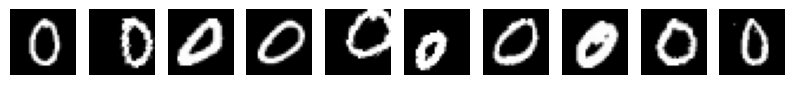

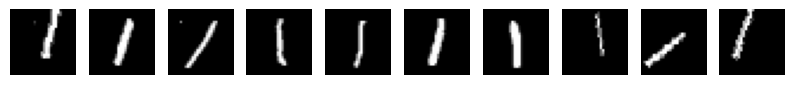

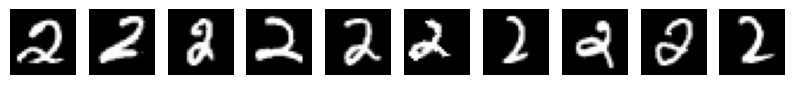

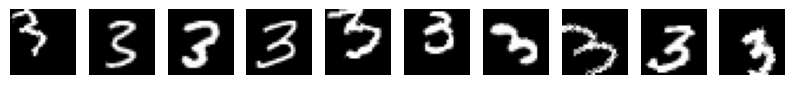

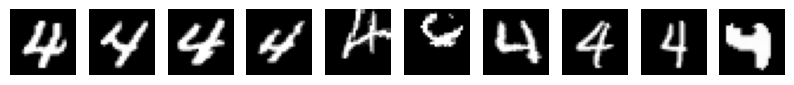

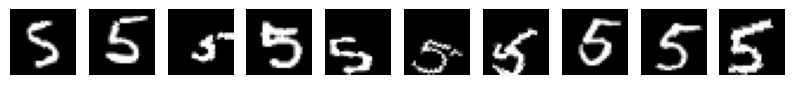

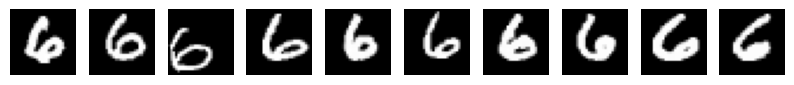

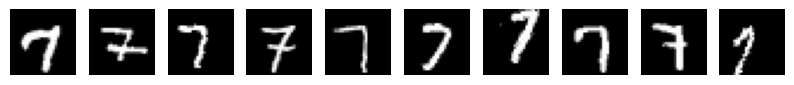

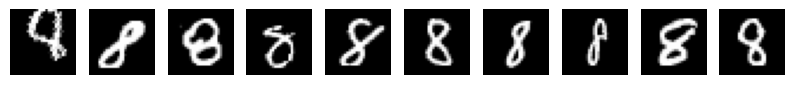

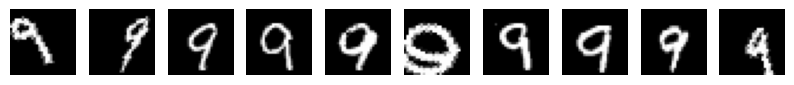

In [7]:

# Define a function to show images
def show_images(images, ncols=5):
    fig, axes = plt.subplots(nrows=1, ncols=ncols, figsize=(10, 10))
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i].squeeze(), cmap="gray")
        ax.axis("off")
    plt.show()

# Iterate through each class and show 5 augmented_ds images
for class_label in range(10):
    num_of_imgs = 10
    selected_indices = np.random.choice(class_indices_dict[class_label], num_of_imgs, replace=False)
    images = [combined_ds[idx][0] for idx in selected_indices]
    labels = [combined_ds[idx][1] for idx in selected_indices]
    show_images(images, ncols=num_of_imgs)


In [8]:
print(f"combined dataset size: {len(combined_ds)}")

# Split the dataset into training and testing sets
train_size = int(0.8 * len(combined_ds))  # Use 80% of the data for training
test_size = len(combined_ds) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(combined_ds, [train_size, test_size])

print(f"Train dataset size: {len(train_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")


combined dataset size: 100000
Train dataset size: 80000
Test dataset size: 20000


In [9]:

# Create data loaders for training and testing
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)


In [10]:
# Image Classifier Neural Network
class ImageClassifier(nn.Module):
    def __init__(self):
        super(ImageClassifier, self).__init__()

        # First convolutional layer
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)  # Batch normalization for conv1
        self.relu1 = nn.ReLU()  # ReLU activation after conv1

        # Second convolutional layer
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)  # Batch normalization for conv2
        self.relu2 = nn.ReLU()  # ReLU activation after conv2

        # Third convolutional layer
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(64)  # Batch normalization for conv3
        self.relu3 = nn.ReLU()  # ReLU activation after conv3

        # Flatten layer to transition from convolutions to fully connected layers
        self.flatten = nn.Flatten()

        # First fully connected layer
        self.fc1 = nn.Linear(64 * 28 * 28, 128)  # 64 channels, 28x28 image size -> 128 units
        self.dropout = nn.Dropout(0.5)  # Dropout layer with 50% dropout probability

        # Final output layer
        self.fc2 = nn.Linear(128, 10)  # 128 units to 10 classes (for MNIST digits)

    def forward(self, x):
        # Layer operations in forward pass
        x = self.relu1(self.bn1(self.conv1(x)))  # conv1 -> batch norm -> ReLU
        x = self.relu2(self.bn2(self.conv2(x)))  # conv2 -> batch norm -> ReLU
        x = self.relu3(self.bn3(self.conv3(x)))  # conv3 -> batch norm -> ReLU
        x = self.flatten(x)  # Flatten the output for fully connected layers
        x = self.dropout(self.relu1(self.fc1(x)))  # Fully connected -> ReLU -> Dropout
        x = self.fc2(x)  # Final output layer
        return x


In [11]:
# Instance of the neural network, loss, optimizer
clf = ImageClassifier().to('cuda')
opt = Adam(clf.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss()
# classes = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]
writer = SummaryWriter("runs/MNIST_Tensorboard")


AssertionError: Torch not compiled with CUDA enabled

In [ ]:
#tensorboard
        # set up a grid of images for each epoch and save it to tensorboard
        # add the loss and accuracy to tensorboard using add_scalar
        # add the model parameters to tensorboard using add_histogram
        # add the model graph to tensorboard using add_graph
        # add the images to tensorboard using add_images
        # add projector to tensorboard using add_embedding

# Training loop
step = 0
epochs_num = 10
epoch_loss = []
epoch_accuracies = []
for epoch in range(epochs_num):
    losses = []
    accuracies = []
    for idx, batch in enumerate(train_loader):
        # Get data
        X, y = batch
        # Move data to GPU
        X, y = X.to('cuda'), y.to('cuda')
        # Get prediction
        yhat = clf(X)
        # Calculate loss
        loss = loss_fn(yhat, y)
        losses.append(loss.item())

        # Apply backpropagation
        opt.zero_grad()
        loss.backward()
        opt.step()

        # Calculate accuracy
        _, predicted = torch.max(yhat, 1)
        accuracy = (predicted == y).float().mean().item()
        accuracies.append(accuracy)

        # TensorBoard logging
        writer.add_scalar('Loss/step', loss.item(), step)
        writer.add_scalar('Accuracy/step', accuracy, step)


        # Log images to TensorBoard (assumes you have a sample image in X)
        writer.add_images('Images/Sample', X, step)
        step += 1


    # Log epoch-level information
    # Log model parameters and gradients
    for name, param in clf.named_parameters():
        writer.add_histogram(name, param.clone().cpu().data.numpy(), step)
        writer.add_histogram(name + '_grad', param.grad.clone().cpu().data.numpy(), step)

    avg_loss = sum(losses) / len(losses)
    avg_accuracy = sum(accuracies) / len(accuracies)
    writer.add_scalar('Loss/epoch', avg_loss, epoch)
    writer.add_scalar('Accuracy/epoch', avg_accuracy, epoch)
    epoch_loss.append(avg_loss)
    epoch_accuracies.append(avg_accuracy)
    print(f"Epoch: {epoch} | Loss: {avg_loss:.5f} | Accuracy: {avg_accuracy:.5f}")



# save the model
with open('model_state.pt', 'wb') as f:
    save(clf.state_dict(), f)


In [ ]:
#plot the loss and accuracy graphs
from matplotlib import style

style.use('dark_background')
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ax[0].plot(range(epochs_num), epoch_loss, label='Training Loss', color='orange')
ax[0].set_title("Training Loss Over Epochs")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Loss")
ax[0].grid(True)
ax[0].legend()


ax[1].plot(range(epochs_num), epoch_accuracies, label='Training Accuracy', color='orange')
ax[1].set_title("Training Accuracy Over Epochs")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Accuracy")
ax[1].grid(True)
ax[1].legend()

plt.show()


In [ ]:
# !rm -rf runs
# writer = SummaryWriter("runs/MNIST_Tensorboard")

# Get all images and labels from the dataset
all_images = []
all_labels = []
for images, labels in test_loader:
    all_images.append(images)
    all_labels.append(labels)

# Concatenate batches to get all data
all_images = torch.cat(all_images, dim=0)
all_labels = torch.cat(all_labels, dim=0)

# Ensure consistency in length
assert all_images.size(0) == len(all_labels), "Length mismatch between images and labels"

# Flatten the images for embedding visualization
all_images_flatten = all_images.view(all_images.size(0), -1)

# Log embeddings to TensorBoard
writer.add_embedding(all_images_flatten, metadata=all_labels.tolist(), label_img=all_images, global_step=step, tag='Embeddings')

# Close the TensorBoard writer
writer.close()

In [ ]:
# Evaluate the model on the test set
clf.eval()  # Set the model to evaluation mode
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to('cuda'), labels.to('cuda')
        outputs = clf(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print(f"Accuracy on the testset: {accuracy * 100:.2f}%")

In [ ]:
%tensorboard --logdir runs/

In [ ]:
#Architecture Map
#Activation Heatmap
#Feature Visualization
# Deep Feature Factorizations
# tensor board Projector



#GradCAM
#Saliency Map
#LIME
#SHAP
#Captum
#Tensorboard